In [20]:
import jax
import jax.numpy as jnp
from jax import grad, vmap, jit
import jax.random as random
from functools import partial
from typing import Callable, Union
from collections import namedtuple
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as ticker

from kernel import imq_kernel, rbf_kernel
from model import model
from methods import VGD
from experiment import experiment, diagnostic_experiment
from calculate_mmd import calculate_mmd_squared
from plot_functions import plot_predictives


def quadratic_reg(theta, x):
    return theta * x**2

quad_model = model(0.5, quadratic_reg, theta_dim=1)

def my_sigmoid(x):
    return 1 / (1 + jnp.exp(-x))

def sigmoid_reg(theta, x):
    return 1 / (1 + jnp.exp(-theta * x))

sig_model = model(0.05, sigmoid_reg, theta_dim=1)

def linear_reg(theta, x):
    return theta[0] + theta[1] * x

linear_model = model(0.8, linear_reg, theta_dim=2)

In [21]:
data_quad_w = quad_model.generate_data(1000, 5, x_min=0.0, x_max=1.0, key=random.PRNGKey(12))
data_sig_w = sig_model.generate_data(1000, 5, x_min=-10.0, x_max=10.0, key=random.PRNGKey(34))

key = random.PRNGKey(12)
rng, key = random.split(key)
n_data = 1000
xs = random.uniform(rng, (n_data,))
true_theta = 5.
sigma = 0.5
phi = 3
rng, key = random.split(key)
ys = (true_theta + phi * random.normal(rng, xs.shape)) * jnp.square(xs)
rng, key = random.split(key)
ys += sigma * random.normal(rng, xs.shape)
data_quad_m = (xs, ys)

sigma = 0.05
def sigmoid(z):
  return 1 / (1 + jnp.exp(-z))
key = jax.random.PRNGKey(42) 
n_data = 1000
key, x_key = random.split(key)
x = random.uniform(x_key, (n_data,), minval=-1.0, maxval=1.0)
key, y_neg_key, y_pos_key = random.split(key, 3)
y_neg = random.uniform(y_neg_key, (n_data,), minval=0.0, maxval=0.5)
y_pos = random.uniform(y_pos_key, (n_data,), minval=0.5, maxval=1.0)
y_observed = jnp.where(x < 0, y_neg, y_pos)
data_sig_m = (x, y_observed)


true_theta = jnp.array([5.0, 3.0]) 
prior_mean = jnp.array([0.0, 0.0])
key = random.PRNGKey(12)
rng, key = random.split(key)
n_data = 1000
xs = random.uniform(rng, (n_data,), minval=-2.0, maxval=2.0)
sigma = 0.8
rng, key = random.split(key)
ys = true_theta[0] + true_theta[1] * xs
ys += sigma * random.normal(rng, xs.shape)
data_linear_w = (xs, ys)

true_theta = jnp.array([5.0, 3.0]) 
prior_mean = jnp.array([0.0, 0.0])
key = random.PRNGKey(12)
rng, key = random.split(key)
n_data = 1000
xs = random.uniform(rng, (n_data,), minval=-2.0, maxval=2.0) 
sigma = 0.8 
rng, key = random.split(key)
ys = true_theta[0] + true_theta[1] * xs + 2 * jnp.square(xs)
ys += sigma * random.normal(rng, xs.shape)
data_linear_m = (xs, ys)

## quad

In [45]:
experiment_quad_w = experiment(quad_model, data_quad_w, n_particles=20, kernel=imq_kernel, key=random.PRNGKey(11))
experiment_quad_w.run(n_steps=5000, step_size=0.001, lengthscale=0.1)

100%|██████████| 5000/5000 [00:07<00:00, 703.19it/s]


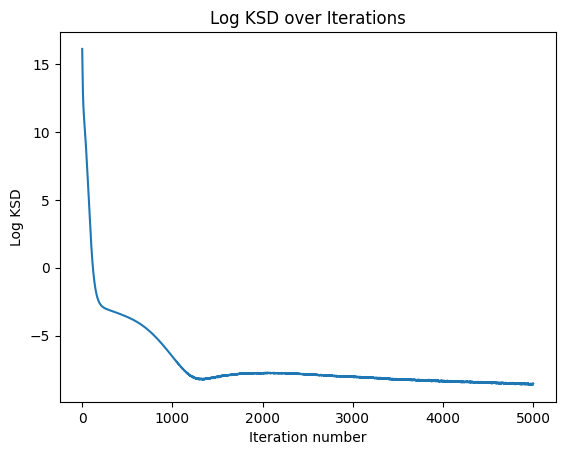

In [47]:
experiment_quad_w.plot_KSD()

[[0.7480118  3.2791514 ]
 [0.22390659 2.6939492 ]]


100%|██████████| 5000/5000 [00:15<00:00, 317.23it/s]


MMD length scale: 1.4646633
Actual mmd 6.133032e-06


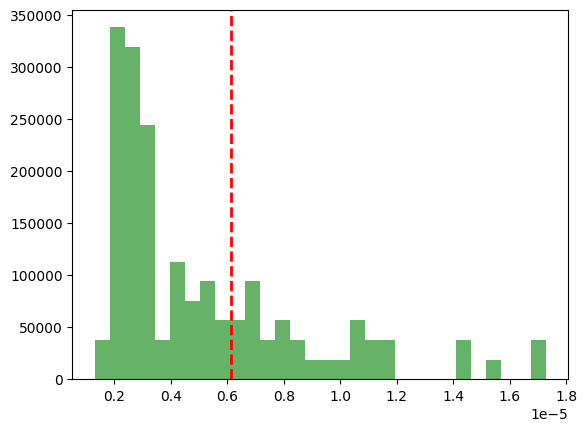

In [48]:
diagnostic_experiment_quad_w = diagnostic_experiment(experiment_quad_w)
all_mmd_values_quad_w, actual_mmd_quad_w = diagnostic_experiment_quad_w.plot_diagnostic()

In [40]:
experiment_quad_m = experiment(quad_model, data_quad_m, n_particles=20, kernel=imq_kernel, key=random.PRNGKey(11))
experiment_quad_m.run(n_steps=5000, step_size=0.0005, lengthscale=0.1)

100%|██████████| 5000/5000 [00:07<00:00, 669.23it/s]


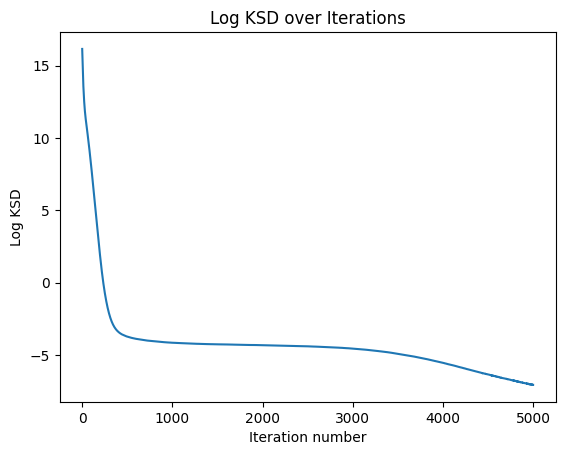

In [41]:
experiment_quad_m.plot_KSD()

In [ ]:
diagnostic_experiment_quad_m = diagnostic_experiment(experiment_quad_m)
all_mmd_values_quad_m, actual_mmd_quad_m = diagnostic_experiment_quad_m.plot_diagnostic()

[[ 3.5093336 11.366126 ]
 [ 2.6707654 10.429802 ]]


100%|██████████| 10000/10000 [00:27<00:00, 360.60it/s]


## sigmoid

In [ ]:
experiment_quad_w = experiment(linear_model, data_linear_w, n_particles=20, kernel=imq_kernel, key=random.PRNGKey(11))
experiment_quad_w.run(n_steps=5000, step_size=0.0005, lengthscale=0.1)

100%|██████████| 5000/5000 [00:07<00:00, 681.82it/s]


[[ 0.75600064  8.772196  ]
 [-0.08256781  7.8358717 ]]


  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:16<00:00, 311.85it/s]


MMD length scale: 3.4555597
Actual mmd 5.4200414e-06


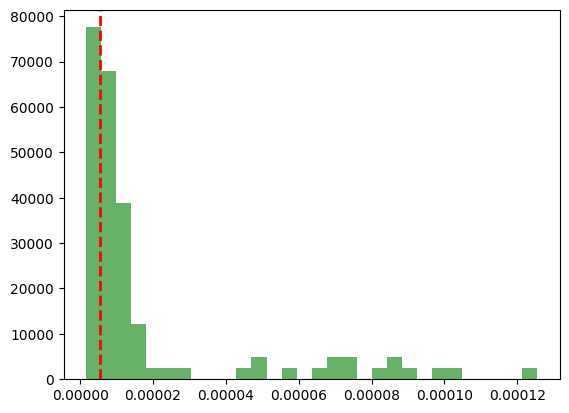

In [ ]:
diagnostic_experiment_quad_w = diagnostic_experiment(experiment_quad_w)
all_mmd_values_quad_w, actual_mmd_quad_w = diagnostic_experiment_quad_w.plot_diagnostic()

In [ ]:
experiment_quad_m = experiment(quad_model, data_quad_m, n_particles=20, kernel=imq_kernel, key=random.PRNGKey(11))
experiment_quad_m.run(n_steps=5000, step_size=0.0005, lengthscale=0.1)

100%|██████████| 5000/5000 [00:07<00:00, 669.23it/s]


In [ ]:
diagnostic_experiment_quad_m = diagnostic_experiment(experiment_quad_m)
all_mmd_values_quad_m, actual_mmd_quad_m = diagnostic_experiment_quad_m.plot_diagnostic()

[[ 3.5093336 11.366126 ]
 [ 2.6707654 10.429802 ]]


100%|██████████| 10000/10000 [00:27<00:00, 360.60it/s]


## linear and quadratic

In [22]:
experiment_landq_w = experiment(linear_model, data_linear_w, n_particles=20, kernel=imq_kernel, key=random.PRNGKey(11))
experiment_landq_w.run(n_steps=10000, step_size=0.0005, lengthscale=0.1)

100%|██████████| 10000/10000 [00:17<00:00, 563.53it/s]


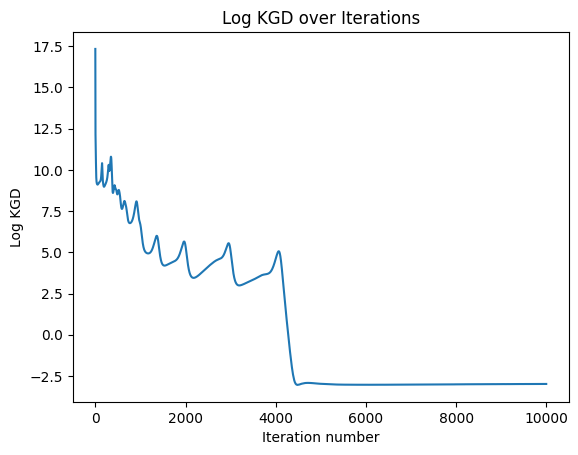

In [24]:
experiment_landq_w.plot_KGD()

[[ 0.7560059   8.772194  ]
 [-0.08256257  7.83587   ]]


100%|██████████| 10000/10000 [00:31<00:00, 318.71it/s]


MMD length scale: 3.4555707
Actual mmd 5.4387265e-06


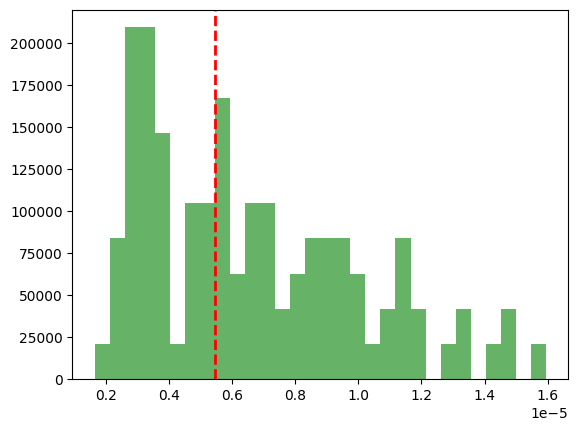

In [27]:
diagnostic_experiment_landq_w = diagnostic_experiment(experiment_landq_w)
all_mmd_values_landq_w, actual_mmd_landq_w = diagnostic_experiment_landq_w.plot_diagnostic()

In [28]:
experiment_landq_m = experiment(linear_model, data_linear_m, n_particles=20, kernel=imq_kernel, key=random.PRNGKey(11))
experiment_landq_m.run(n_steps=10000, step_size=0.0005, lengthscale=0.1)

100%|██████████| 10000/10000 [00:12<00:00, 806.95it/s]


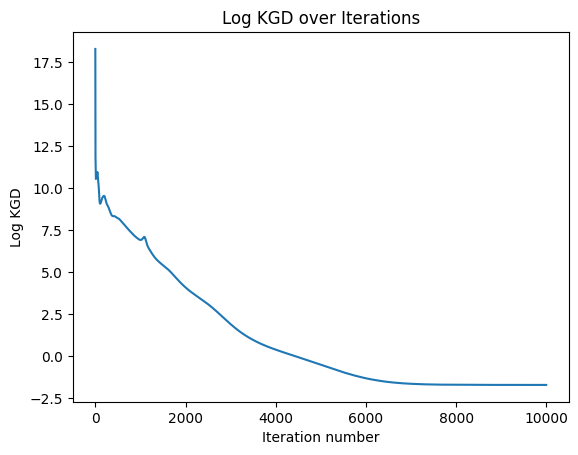

In [30]:
experiment_landq_m.plot_KGD()

[[ 3.5093336 11.366126 ]
 [ 2.6707654 10.429802 ]]


100%|██████████| 10000/10000 [00:27<00:00, 360.60it/s]


MMD length scale: 4.9514174
Actual mmd 0.001738141


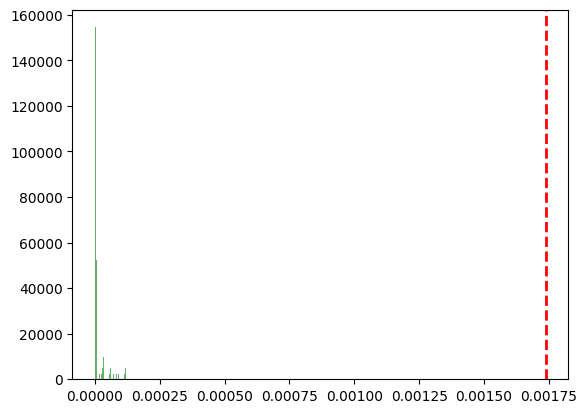

In [29]:
diagnostic_experiment_landq_m = diagnostic_experiment(experiment_landq_m)
all_mmd_values_landq_m, actual_mmd_landq_m = diagnostic_experiment_landq_m.plot_diagnostic()